In [ ]:
#Imports
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the data
df = pd.read_csv('../data/train_enc.csv')
df.head

In [ ]:
# Split the data into training and validation sets
train, validation = train_test_split(df, test_size=0.2, random_state=200, shuffle=True)

print(train.shape)
print(validation.shape)

In [ ]:
# split the columns into features and target; ie x y split
target = 'SalePrice'
X_train = train.drop(target, axis=1)
y_train = train[target]

X_validation = validation.drop(target, axis=1)
y_validation = validation[target]

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

## Train the model (with default hyperparameters)

In [ ]:
# Create the model
gbr_model = GradientBoostingRegressor()

gbr_model.fit(X_train, y_train)

# R2 score
gbr_model.score(X_validation, y_validation)

Note that the score is already better than simple Random Forest Regressor. This is because Gradient Boosting is an ensemble method that builds trees sequentially, where each tree tries to correct the errors of the previous one. This is different from Random Forest, where each tree is built independently.

## Hyperparameter tuning using GridSearchCV

In [30]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to test
param_grid_extended = {
    'n_estimators': [100, 125, 150, 175, 200, 225, 250, 275, 300],
    'learning_rate': [0.01, 0.05, 0.01, 0.5, 1],
    'max_depth': [3, 5, 7]
}

simple_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(GradientBoostingRegressor(), simple_param_grid, cv=3, scoring='r2', return_train_score=True)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Save the best estimator
gbr_model = grid_search.best_estimator_

# Get the results of the grid search
results = pd.DataFrame(grid_search.cv_results_)

# Print the best parameters and corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}
Best score:  -27186.40331028834


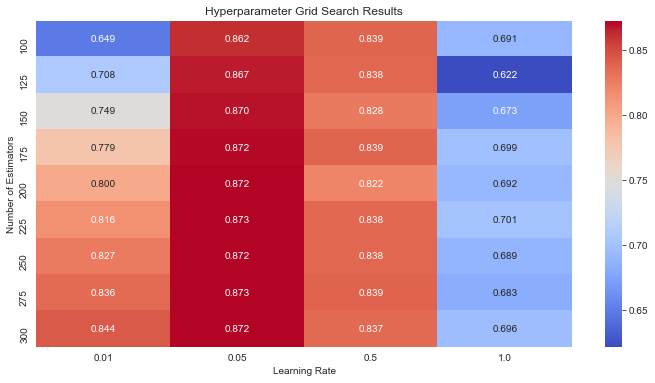

In [26]:
results = results.drop_duplicates(subset=['param_n_estimators', 'param_learning_rate'])

# Reshape the results for the heatmap
heatmap_data = results.pivot(index='param_n_estimators', columns='param_learning_rate', values='mean_test_score')

# Create a heatmap
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='coolwarm', ax=ax)
plt.xlabel('Learning Rate')
plt.ylabel('Number of Estimators')
plt.title('Hyperparameter Grid Search Results')
plt.show()

##### The best parameters are n_estimators=200, learning_rate=0.1, and max_depth=3

## Repeat the process with the best parameters

In [28]:
# Perform cross-validation and get scores
r2_scores = cross_val_score(gbr_model, X_train, y_train, cv=5, scoring='r2')

# Print the scores
for score in r2_scores:
    print(score)

0.9153852603049084
0.9092887057197868
0.89326176226237
0.6932702610382726
0.8989873304841779


In [ ]:
# gbr_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3)
r2_scores = []

# Repeat the process 20 times with the best parameters, shuffling the data each time
for i in range(20):
    train, validation = train_test_split(df, test_size=0.2, random_state=i, shuffle=True)

    target = 'SalePrice'
    train_x = train.drop(target, axis=1)
    train_y = train[target]
    validation_x = validation.drop(target, axis=1)
    validation_y = validation[target]

    # Fit the model
    gbr_model.fit(train_x, train_y)

    score = gbr_model.score(validation_x, validation_y)
    print(score)
    r2_scores.append(score)

In [ ]:
# Plot the r2 scores to show consistency
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(10), y=r2_scores, ax=ax)
ax.set_title('R2 Score Lineplot')
# ax.set_ylim(0.60, 1.0)
ax.set_xticks(range(0, 21, 2))
plt.show()

##### The scores are fairly consistent, so we can be confident in the model's performance.

Shuffling the data allows us to see the variation in the model's performance. The model's performance is consistent across different random states, so we can be confident in the model's performance. The R2 score is consistently above 0.8 (except a couple outliers), which is a good result for this dataset.

## Submission to Kaggle
##### Only run once at the end

In [29]:
# Record predictions for the test set
test = pd.read_csv('../data/test_enc.csv')
test_predictions = gbr_model.predict(test)

# add the Id column to the predictions
df_test = pd.read_csv('../data/test.csv')
test_predictions = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': test_predictions})

# Save the predictions to a CSV file
test_predictions.to_csv('../gbr_test_predictions_3.csv', index=False)

test_predictions

,Id,SalePrice
0,1461,121467.320737
1,1462,163223.665347
2,1463,184529.463941
3,1464,184655.808914
4,1465,196431.006467
...,...,...
1454,2915,85577.217037
1455,2916,73726.599525
1456,2917,164014.737260
1457,2918,126003.603645
